In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, precision_score, recall_score, roc_auc_score

from itertools import islice
from functools import partial
import mxnet as mx
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from gluonts.dataset.loader import TrainDataLoader
from gluonts.mx import DeepAREstimator
from gluonts.mx.util import get_hybrid_forward_input_names
from gluonts.mx.trainer import Trainer
from gluonts.mx.batchify import batchify
from gluonts.dataset.repository.datasets import get_dataset

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from gluonts.dataset.common import ListDataset

In [2]:
import json
  
# Opening JSON file
f = open('data/deepar_data.json')
  
# returns JSON object as a dictionary
json_data = json.load(f)

json_load = json.loads(json_data)
data_restored = json_load["data"]

In [3]:
len(data_restored)

3331

In [4]:
freq = "7D"             # the frequency of our data, here daily
context_length    = 21 # train on this number of days
prediction_length =  14 # predict these many days, these are removed from the end of the training data

In [5]:
train_ds  = ListDataset(data_iter = data_restored, freq=freq)

In [6]:
from gluonts.mx import DeepAREstimator

estimator = DeepAREstimator(
        prediction_length=prediction_length,
        context_length = context_length,
        freq=freq,
        use_feat_dynamic_real = True,
        trainer=Trainer(
            learning_rate=1e-3, epochs=2, num_batches_per_epoch=100
        ),
    )

In [7]:
%%time
# instead of calling `train` method, we call `train_model` that returns more things including the training model
train_output = estimator.train_model(train_ds)
print("Done")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.61it/s, epoch=2/2, avg_epoch_loss=8.94]

Done
CPU times: user 9.16 s, sys: 156 ms, total: 9.32 s
Wall time: 8.99 s


In [8]:
input_names = get_hybrid_forward_input_names(
        type(train_output.trained_net)
    )

# we construct a data_entry that contains 500 random windows
batch_size = 500
num_samples = 100
instance_splitter = estimator._create_instance_splitter("training")

In [9]:
training_data_loader = TrainDataLoader(
        dataset=train_ds,
        transform=train_output.transformation + instance_splitter,
        batch_size=batch_size,
        num_batches_per_epoch=estimator.trainer.num_batches_per_epoch,
        stack_fn=partial(
            batchify, ctx=estimator.trainer.ctx, dtype=estimator.dtype
        ),
    )

data_entry = next(iter(training_data_loader))

In [10]:
# we now call the train model to get the predicted distribution on each window
# this allows us to investigate where are the biggest anomalies
context_length = train_output.trained_net.context_length
prediction_length = train_output.trained_net.prediction_length

distr = train_output.trained_net.distribution(
    *[data_entry[k] for k in input_names]
)

In [11]:
# gets all information into numpy array for further plotting
samples = distr.sample(num_samples).asnumpy()
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])
target = mx.ndarray.concat(
    data_entry["past_target"], data_entry["future_target"], dim=1
)
target = target[:, -(context_length + prediction_length) :]
nll = -distr.log_prob(target).asnumpy()
target = target.asnumpy()
mean = samples.mean(axis=0)
percentiles = np.percentile(samples, axis=0, q=[10.0, 90.0])

9936 283 31


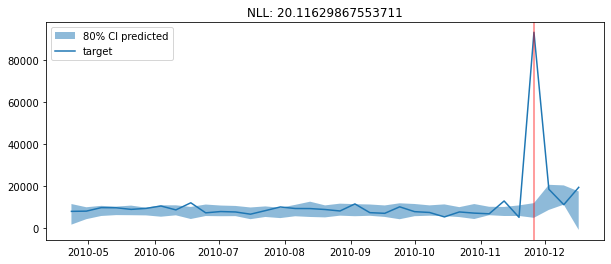

14258 407 13


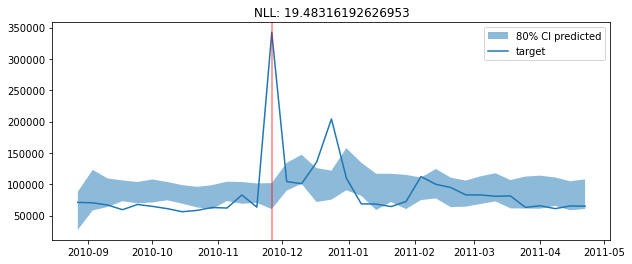

In [12]:
# NLL indices from largest to smallest
sorted_indices = np.argsort(nll.reshape(-1))[::-1]

anomaly_date_in_series = []
anomaly_sales_in_series = []
anomaly_i_t_in_series = []

anamoly_dict = {}
k_list = []

# shows the series and times when the 20 largest NLL were observed
for k in sorted_indices[:2]:
    i = k // nll.shape[1]
    t = k % nll.shape[1]
    k_list.append(k)
    print(k,i,t)

    time_index = pd.period_range(
        data_entry["forecast_start"][i],
        periods=context_length + prediction_length,
        freq=data_entry["forecast_start"][i].freq,
    )
    time_index -= context_length * time_index.freq

    plt.figure(figsize=(10, 4))
    plt.fill_between(
        time_index.to_timestamp(),
        percentiles[0, i],
        percentiles[-1, i],
        alpha=0.5,
        label="80% CI predicted",
    )
    anomaly_date_in_series.append(time_index[t].strftime('%Y-%m-%d'))
    anomaly_sales_in_series.append(target[i][t])
    anomaly_i_t_in_series.append(str(i) + "_" + str(t))
    anamoly_dict[time_index[t].strftime('%Y-%m-%d')] = target[i][t]
    
    plt.plot(time_index.to_timestamp(), target[i], label="target")
    plt.axvline(time_index[t].to_timestamp(), alpha=0.5, color="r")
    plt.title(f"NLL: {nll[i, t]}")
    plt.legend()
    plt.show()

In [13]:
# NLL indices from largest to smallest
sorted_indices = np.argsort(nll.reshape(-1))[::-1]

anomaly_date_in_series = []
anomaly_sales_in_series = []
anomaly_i_t_in_series = []

anamoly_dict = {}
k_list = []
count = 0
# shows the series and times when the 20 largest NLL were observed
for k in sorted_indices[:1000]:
    count+=1
    if(count%100==0): print(count)
    i = k // nll.shape[1]
    t = k % nll.shape[1]
    k_list.append(k)
    # print(k,i,t)

    time_index = pd.period_range(
        data_entry["forecast_start"][i],
        periods=context_length + prediction_length,
        freq=data_entry["forecast_start"][i].freq,
    )
    time_index -= context_length * time_index.freq
    
    anomaly_date_in_series.append(time_index[t].strftime('%Y-%m-%d'))
    anomaly_sales_in_series.append(target[i][t])
    anomaly_i_t_in_series.append(str(i) + "_" + str(t))
    anamoly_dict[time_index[t].strftime('%Y-%m-%d')] = target[i][t]

100
200
300
400
500
600
700
800
900
1000


In [14]:
len(time_index)

35

In [15]:
len(anomaly_date_in_series), len(anomaly_sales_in_series), len(anomaly_i_t_in_series), len(anamoly_dict), len(k_list)

(1000, 1000, 1000, 145, 1000)

In [16]:
anamoly_df = pd.DataFrame(columns=['Date', 'weekly_sales'])
anamoly_df['Date'] = anomaly_date_in_series
anamoly_df['weekly_sales'] = anomaly_sales_in_series
anamoly_df['k_indices'] = k_list

In [17]:
anamoly_df['Date'] = pd.to_datetime(anamoly_df['Date'])

In [18]:
anamoly_df_req = anamoly_df[anamoly_df['Date']>='2010-02-05'].reset_index(drop=True)

In [19]:
import math
anamoly_df_req['sales_high'] = anamoly_df_req['weekly_sales'].apply(np.ceil)
anamoly_df_req['sales_low'] = anamoly_df_req['weekly_sales'].apply(np.floor)

In [20]:
anamoly_df_req.shape

(551, 5)

In [21]:
df_raw = pd.read_csv('data/walmart_cleaned.csv')

In [22]:
anamoly_df_req.shape[0]

551

In [23]:
anamoly_df_req.head()

,Date,weekly_sales,k_indices,sales_high,sales_low
0,2010-11-26,93034.796875,9936,93035.0,93034.0
1,2010-11-26,342578.656250,14258,342579.0,342578.0
2,2010-12-24,39721.570312,8010,39722.0,39721.0
3,2010-12-17,25437.150391,8009,25438.0,25437.0
4,2010-11-26,113851.859375,12069,113852.0,113851.0


In [24]:
index_val = []
k_indices_diplay = []

for i in anamoly_df_req.iterrows():
    # print(i[1]['Date'].strftime('%Y-%m-%d'))
    try:
        temp = df_raw[(df_raw['Date']==i[1]['Date'].strftime('%Y-%m-%d')) & (df_raw['Weekly_Sales'] == round(i[1]['weekly_sales'],2))]['Unnamed: 0']
        # print("try", i[1]['weekly_sales'])
        index_val.append(temp.iloc[0])
        k_indices_diplay.append(i[1]['k_indices'])
        # print(temp.shape[0])
        
    except:
        try:
            temp = df_raw[(df_raw['Weekly_Sales'] == round(i[1]['weekly_sales'],2))]['Unnamed: 0']
            index_val.append(temp.iloc[0])
            k_indices_diplay.append(i[1]['k_indices'])
        except:
            temp = df_raw[(df_raw['Date']==i[1]['Date'].strftime('%Y-%m-%d')) & 
                (df_raw['Weekly_Sales'] <= i[1]['sales_high']) & (df_raw['Weekly_Sales'] >= i[1]['sales_low'])]['Unnamed: 0']
            index_val.append(temp.iloc[0])
            k_indices_diplay.append(i[1]['k_indices'])

In [25]:
len(index_val), len(set(index_val)), len(k_indices_diplay)

(551, 499, 551)

In [26]:
# df_raw[df_raw['Unnamed: 0'].isin(index_val)].head()

In [27]:
deepar_outliers = df_raw[df_raw['Unnamed: 0'].isin(index_val)].reset_index(drop = True)[['Date','Store',
                                                                                       'Dept','Weekly_Sales']]

In [28]:
deepar_outliers.head()

,Date,Store,Dept,Weekly_Sales
0,2010-02-12,1,95.0,111390.36
1,2010-03-12,1,47.0,-698.00
2,2010-03-26,1,5.0,38971.89
3,2010-04-02,1,51.0,0.75
4,2010-04-02,1,16.0,46060.69


In [29]:
deepar_outliers.to_csv('data/deepar_outliers.csv',index=False)

102614.71


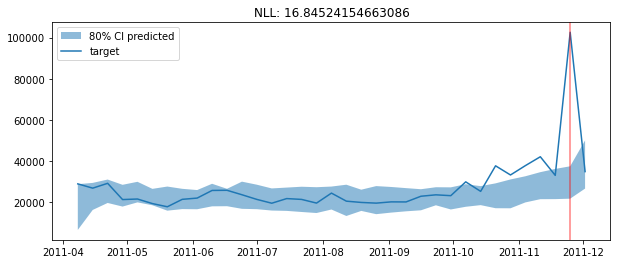

39721.57


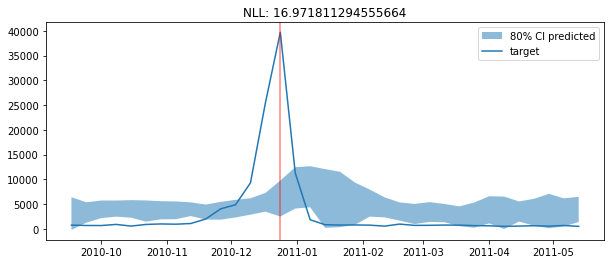

25471.97


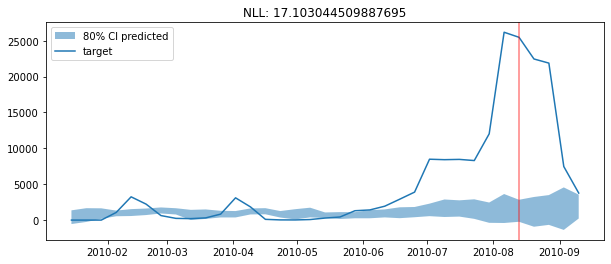

26177.86


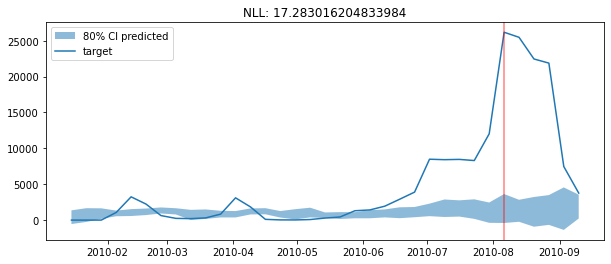

33614.93


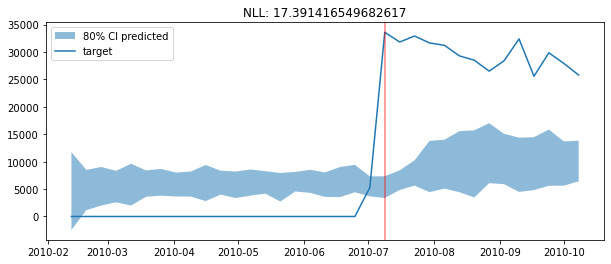

113851.86


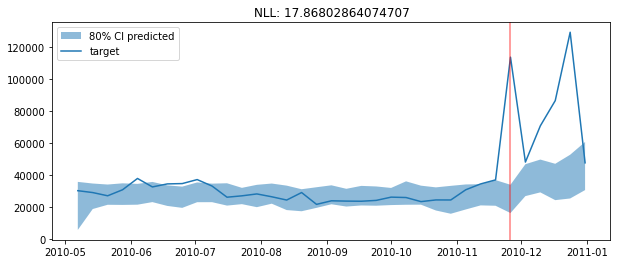

25437.15


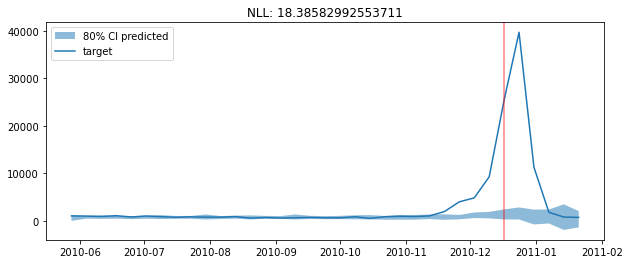

39721.57


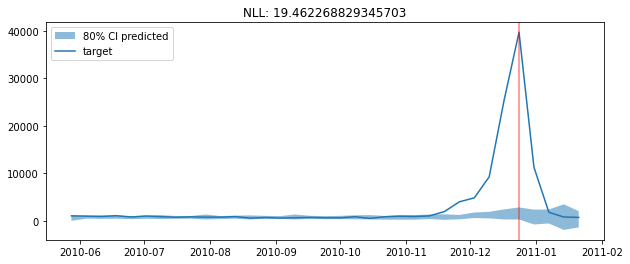

342578.66


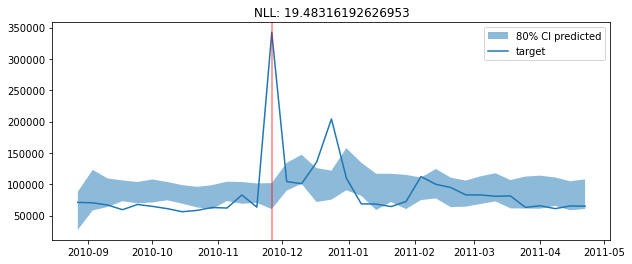

93034.8


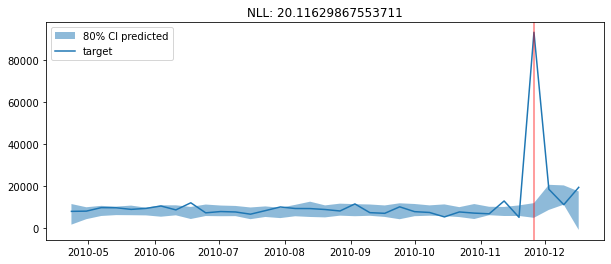

In [30]:
# NLL indices from largest to smallest
sorted_indices = np.argsort(nll.reshape(-1))[::-1]

# shows the series and times when the 20 largest NLL were observed
for k in sorted_indices[:10][::-1]:
    if(k not in k_indices_diplay):
        continue
    
    
    i = k // nll.shape[1]
    t = k % nll.shape[1]
    print(target[i][t])

    time_index = pd.period_range(
        data_entry["forecast_start"][i],
        periods=context_length + prediction_length,
        freq=data_entry["forecast_start"][i].freq,
    )
    time_index -= context_length * time_index.freq

    plt.figure(figsize=(10, 4))
    plt.fill_between(
        time_index.to_timestamp(),
        percentiles[0, i],
        percentiles[-1, i],
        alpha=0.5,
        label="80% CI predicted",
    )
    
    plt.plot(time_index.to_timestamp(), target[i], label="target")
    plt.axvline(time_index[t].to_timestamp(), alpha=0.5, color="r")
    plt.title(f"NLL: {nll[i, t]}")
    plt.legend()
    plt.show()